In [ ]:
!pip install simpletransformers
!pip install contractions

In [ ]:
import pandas as pd
import numpy as np
import random 
import os
import re
import pandas as pd
import numpy as np
import contractions
from bs4 import BeautifulSoup
from html import unescape
import torch
from simpletransformers.classification import ClassificationModel
from sklearn.metrics import *
from sklearn.model_selection import *
from scipy.special import softmax
import matplotlib.pyplot as plt

In [ ]:
#Text Preprocessing Libraries
import re
import nltk
import string
nltk.download('punkt', 'stopwords')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english")) 


[nltk_data] Downloading package punkt to stopwords...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Loading Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/kaggle-nabil-badri/olid-training-v1.0.tsv", sep='\t',error_bad_lines=False)
X_test=pd.read_csv('/content/drive/MyDrive/kaggle-nabil-badri/testset-levela.tsv',sep="\t")
y_test=pd.read_csv( '/content/drive/MyDrive/kaggle-nabil-badri/labels-levela.csv',header=None).iloc[:,-1]

In [ ]:
X_train = pd.DataFrame()
X_train['text'] = df['tweet']
X_train['label'] = df['subtask_a'] #  change data["subtask_a"] to  data["subtask_b"]
X_train.head()

,text,label
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT


In [ ]:
X_train.label.value_counts()

NOT    8840
OFF    4400
Name: label, dtype: int64

In [ ]:
#Encoding
X_train.label.replace({'OFF':1,'NOT':0},inplace=True)
X_train.head()

,text,label
0,@USER She should ask a few native Americans wh...,1
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1
2,Amazon is investigating Chinese employees who ...,0
3,"@USER Someone should'veTaken"" this piece of sh...",1
4,@USER @USER Obama wanted liberals &amp; illega...,0


### Setting up RoBERTa

In [ ]:
def random_seed(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [ ]:
seed=7
random_seed(seed)

In [ ]:
def get_model(model_type, model_name, n_epochs = 2, seq_len = 100, lr = 2e-5,):
  model = ClassificationModel(model_type, model_name,num_labels=2, args={
                                                                         'reprocess_input_data': True,
                                                                         'overwrite_output_dir': True,
                                                                         'fp16': False,
                                                                         'do_lower_case': False,
                                                                         'num_train_epochs': n_epochs,
                                                                         'max_seq_length': seq_len,
                                                                         "learning_rate":lr,
                                                                         "save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False
                                                                         })
  return model

Cleaning Text

In [ ]:
lemmatizer = WordNetLemmatizer()
corpus_train = []
for i in X_train['text']:
    x=i.lower()
    x=x.replace('@user','')
    x=x.replace('@[\w\-]+','')
    x=x.translate(str.maketrans('', '', string.punctuation))
    x = re.sub('[^A-Za-z]', ' ', x)
    x=re.sub('\s+',' ',x)
    x=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',x) #url
    x = [lemmatizer.lemmatize(token) for token in x.split(" ")]
    x = [word for word in x if not word in stop_words]
    x=" ".join(x)
    corpus_train.append(x) 
corpus_test = []
for i in X_test['tweet']:
    x=i.lower()
    x=x.replace('@user','')
    x=x.replace('@[\w\-]+','')
    x=x.translate(str.maketrans('', '', string.punctuation))
    x = re.sub('[^A-Za-z]', ' ', x)
    x=re.sub('\s+',' ',x)
    x=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',x) #url
    x = [lemmatizer.lemmatize(token) for token in x.split(" ")]
    x = [word for word in x if not word in stop_words]
    x=" ".join(x)
    corpus_test.append(x) 

In [ ]:
X_train['text']=corpus_train

In [ ]:
X_test['tweet'] = corpus_test

In [ ]:
model = get_model('roberta', 'roberta-base', n_epochs=1,lr=2e-5)
model.train_model(X_train)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:391: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/13240 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1655 [00:00<?, ?it/s]

(1655, 0.5126527935694172)

Generating Predictions

In [ ]:
y_test.replace({'OFF':1,'NOT':0},inplace=True)

In [ ]:
X_test.drop(['id'],1,inplace=True)

In [ ]:
X_test['label'] = y_test

In [ ]:
Predictions = model.eval_model(X_test)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:970: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/860 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/108 [00:00<?, ?it/s]

Metrics


In [ ]:
raw_outputs_vals = softmax(Predictions[1],axis=1)
raw_outputs_vals.argmax(axis=1)
print(classification_report(y_test,raw_outputs_vals.argmax(axis=1), target_names=(["not offensive","offensive"])))

               precision    recall  f1-score   support

not offensive       0.84      0.94      0.89       620
    offensive       0.78      0.53      0.63       240

     accuracy                           0.83       860
    macro avg       0.81      0.73      0.76       860
 weighted avg       0.82      0.83      0.81       860



In [ ]:
metric =(accuracy_score(y_test,raw_outputs_vals.argmax(axis=1)), 
        f1_score(y_test,raw_outputs_vals.argmax(axis=1), average='macro'),
        recall_score(y_test,raw_outputs_vals.argmax(axis=1)),
        precision_score(y_test,raw_outputs_vals.argmax(axis=1)))

(0.0, 1.0)

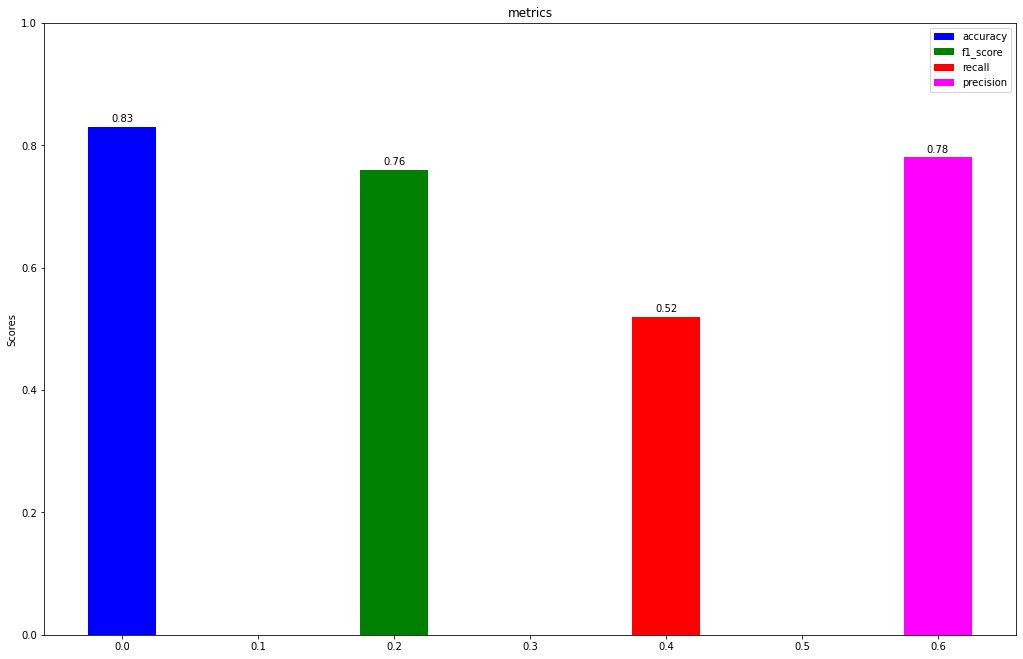

In [ ]:
fig = plt.figure()
fig.set_size_inches(13.5, 8.5)
ax = fig.add_axes([0,0,1,1])
rect1 = ax.bar(0.00,round(metric[0], 2), color = 'b', width = 0.05)
rect2 = ax.bar(0.20, round(metric[1], 2), color = 'g', width = 0.05)
rect3 = ax.bar(0.40, round(metric[2], 2) , color = 'r', width = 0.05)
rect4 = ax.bar(0.60, round(metric[3], 2) , color = (1, 0, 1), width = 0.05)

ax.set_ylabel('Scores')
ax.set_title('metrics')
def autolabel(rects):
  """Attach a text label above each bar in *rects*, displaying its height."""
  for rect in rects:
      height = rect.get_height()
      ax.annotate('{}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom')

autolabel(rect1)
autolabel(rect2)
autolabel(rect3)
autolabel(rect4)
ax.legend(labels=['accuracy', 'f1_score', 'recall', 'precision'],loc='best')
plt.ylim(0, 1)